In [447]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 9999)
pd.set_option('display.max_rows', 9999)

### Import Trades from file generated by code and create Prices dataframe

In [403]:
# Read generated buys
trades = pd.read_feather('/Users/renovieira/Desktop/trades.feather')
business_days = set(trades['just_date'].unique())

### Create DataFrames of Buys and Sells
#### Buys

In [436]:
def extract_buys(df, list_of_signals, buy_date):
    
    # Create empty list to store results
    buys_list = []
    
    # Columns
    columns_list = ['symbol', 'date', 'price', 'order_type', 'shares', 'total', 'strategy']
    
    # Empty dataframe
    empty_df = pd.DataFrame([[0,0,0,0,0,0]], columns = ['symbol', 'date', 'price', 'order_type', 'shares', 'total'])
    
    # Loop through different strategies
    for buy_signal in list_of_signals:

        # Create dataframe with buys
        buys = df[(df['just_date'] == buy_date) 
                    & (df[buy_signal] == True)
                    & (df['sell_signal?'] != True)][['symbol', 'just_date', 'close_price_x']]

        # Create some other columns
        buys['order_type'] = 'buy'
        buys['shares'] = 100 / buys['close_price_x']
        buys['total'] = buys['shares'] * buys['close_price_x']
        buys['strategy'] = buy_signal
       
        # If length is zero then create empty record
        if len(buys) == 0:
            buys_none = empty_df
            buys_none['strategy'] = buy_signal
            buys_list.append(buys_none.values.tolist()[0])
        
        # Else then append buys
        else:
            buys.columns = columns_list
            buys_list.append(buys.values.tolist()[0])
    
    # Transform list into a Dataframe
    buys_df = pd.DataFrame(buys_list, columns = columns_list)
    
    return buys_df

### Sells

In [437]:
def extract_sells(trades, date):
    # Search for the sell_signal on a given day
    sells = trades[(trades['just_date'] == date) 
                & (trades['sell_signal?'] == True)][['symbol', 'just_date', 'close_price_x']]
    
    # Create Column with order type
    sells['order_type'] = 'sell'
    
    # Rename a columns
    sells.columns = ['symbol', 'sell_date', 'price', 'order_type']
    
    return sells

### Loop Through Days
Logic:
- See if there are any buys on that day and add to holdings_df if that's the case.
- See if there are any sells using the sell_signal and limits (max_loss and max_holdings).
- If you have sells, then remove them from holdings and add to rgl_df.

In [444]:
# Define Min, Max and Moving Dates
min_date = trades['just_date'].min()
max_date = trades['just_date'].max()
number_of_days = (max_date - min_date).days + 1
count = 1

# The moving date gives sells/buys on a given day.
moving_date = min_date

# List of buy signals to be analyzed
list_of_signals = ['buy_signal?1', 'buy_signal?2','buy_signal?3','buy_signal?4']

# Max loss and holdings
max_loss = -0.10
max_holdings = 30

# Start tracking time
start_time = time.time()

# While moving date is less or equal to max_date
while moving_date <= max_date:
    
    # If it's the first date, the process is different, because holdings and rgl need to be created yet
    if moving_date == min_date:
        
        # Figure out buys
        buys = extract_buys(trades, list_of_signals, moving_date)
        
        # Create holdings
        holdings_df = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # As of Date and close_price columns
        holdings_df['as_of_date'] = moving_date
        holdings_df['day_close_price'] = 0
        
        # Convert symbols to string to avoid merging problems in the future
        holdings_df['symbol'] = holdings_df['symbol'].astype(str)
        
        # Create RGL
        rgl_df = holdings_df.copy()
                
    # If it's not the first day:
    else:
        
        # Create prices dataframe from trades
        prices = trades[trades['just_date'] == moving_date][['symbol', 'close_price_x']]
        prices.columns = ['symbol', 'day_close_price']
        
        # Get Previous Day's Holdings and store the number of securities held on that day
        temp_holdings = holdings_df.drop('day_close_price', axis=1)
        previous_holdings = temp_holdings[temp_holdings['as_of_date'] == previous_day]
        previous_holdings.drop(['as_of_date'], axis=1, inplace=True)
        number_of_symbols = len(previous_holdings['symbol'].unique())
        
        # Figure out sells and create list of symbols with sell signals
        sells = extract_sells(trades, moving_date)
        sold_symbols = set(sells['symbol'])
        
        # Remove sells from Previous Day's Holdings
        holdings_no_sells = previous_holdings[~previous_holdings['symbol'].isin(sold_symbols)]
        
        # Do the following with the securities that were left (only in business days)
        if moving_date in business_days:
        
            # Create new sell signals based on max_loss and max_holdings
            # Calculate % gain
            stop_loss_sells = pd.merge(holdings_no_sells, prices, on='symbol', how='left')
            stop_loss_sells['market_value'] = stop_loss_sells['shares'] * stop_loss_sells['day_close_price']
            stop_loss_sells['%_gain'] = (stop_loss_sells['market_value'] / stop_loss_sells['cost_basis']) - 1
            
            # Create column with date and remove 0's from sells
            stop_loss_sells['just_date'] = moving_date
            stop_loss_sells = stop_loss_sells[stop_loss_sells['buy_date'] != 0]
            
            # If sell signals were generated from this, then do the following
            if len(stop_loss_sells) > 0:
                
                # Calculate the number of Holding Days, which is the different between buy_date and just_date
                stop_loss_sells['holding_days'] = (stop_loss_sells['just_date'] - stop_loss_sells['buy_date'])
                stop_loss_sells['holding_days'] = stop_loss_sells['holding_days'].dt.days
                
                # Create Sell Signal if % gain is below max_loss OR holding_days is greater then max_holdings
                stop_loss_sells = stop_loss_sells[
                    (stop_loss_sells['%_gain'] < max_loss)
                   |(stop_loss_sells['holding_days'] > max_holdings)][['symbol', 'just_date', 'day_close_price']]
                
                # Create order_type column and rename columns
                stop_loss_sells['order_type'] = 'sell'
                stop_loss_sells.columns = ['symbol', 'sell_date', 'price', 'order_type']

                # Concatenate new sells with sells generated from sell_signal? 
                sells = pd.concat([sells, stop_loss_sells])
                
                # Create list of sold symbols
                sold_symbols = set(sells['symbol'])

            # Remove sells from Previous Day's Holdings, again. This time including sells from loss and holding limits
            holdings_no_sells = previous_holdings[~previous_holdings['symbol'].isin(sold_symbols)]
        
        # Store Realized Gains/Losses in rgl_df only if there are symbols in sold_symbols
        if len(sold_symbols) > 0:
            
            # Create Dataframe by merging Previous Day's Holdings with sells dataframe
            today_rgl = pd.merge(previous_holdings, sells, how='inner', on='symbol')
            
            # Get prices in which the securities were sold
            today_rgl = pd.merge(today_rgl, prices, how='left', on='symbol')
            
            # Create as of date column and calculate gains and market value
            today_rgl['as_of_date'] = moving_date
            today_rgl['market_value'] = today_rgl['shares'] * today_rgl['day_close_price']
            today_rgl['$_gain'] = today_rgl['market_value'] - today_rgl['cost_basis']
            today_rgl['%_gain'] = (today_rgl['market_value'] / today_rgl['cost_basis']) - 1
            
            # Add that into master rgl_df
            rgl_df = pd.concat([rgl_df, today_rgl])
        
        # Now that sold securities have been removed from holdings, it's time to look for buys
        buys = extract_buys(trades, list_of_signals, moving_date)
        buys = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        buys.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # Add Buys to holdings
        today = pd.concat([holdings_no_sells, buys])
        today['as_of_date'] = moving_date
         
        # Number of Symbols in new holdings (Previous Day's minus sells, plus new buys)
        number_of_symbols = len(today['symbol'].unique())
        
        # If you have more than one security (there's a placeholder, so we need more than one)
        # Then pull prices to calculate market value and % gain
        if number_of_symbols > 1:
            today = pd.merge(today, prices, on='symbol', how='left')
            today['market_value'] = today['shares'] * today['day_close_price']
            today['%_gain'] = (today['market_value'] / today['cost_basis']) - 1
        
        # Append with master holdings
        holdings_df = holdings_df.append(today)
        
        # Completion %
        print(str(round((100 * count / number_of_days),2)) + ' % - ' + str(round(time.time() - start_time, 1)) + ' seconds.')
    
    # Previous day becomes moving_date and moving date becomes moving date plus one day
    previous_day = moving_date
    moving_date += timedelta(days=1)
    count += 1

0.17 %
0.25 %
0.33 %
0.42 %
0.5 %
0.58 %
0.67 %
0.75 %
0.83 %
0.92 %
1.0 %
1.08 %
1.17 %
1.25 %
1.33 %
1.42 %
1.5 %
1.58 %
1.67 %
1.75 %
1.83 %
1.92 %
2.0 %
2.09 %
2.17 %
2.25 %
2.34 %
2.42 %
2.5 %
2.59 %
2.67 %
2.75 %
2.84 %
2.92 %
3.0 %
3.09 %
3.17 %
3.25 %
3.34 %
3.42 %
3.5 %
3.59 %
3.67 %
3.75 %
3.84 %
3.92 %
4.0 %
4.09 %
4.17 %
4.25 %
4.34 %
4.42 %
4.5 %
4.59 %
4.67 %
4.75 %
4.84 %
4.92 %
5.0 %
5.09 %
5.17 %
5.25 %
5.34 %
5.42 %
5.5 %
5.59 %
5.67 %
5.75 %
5.84 %
5.92 %
6.01 %
6.09 %
6.17 %
6.26 %
6.34 %
6.42 %
6.51 %
6.59 %
6.67 %
6.76 %
6.84 %
6.92 %
7.01 %
7.09 %
7.17 %
7.26 %
7.34 %
7.42 %
7.51 %
7.59 %
7.67 %
7.76 %
7.84 %
7.92 %
8.01 %
8.09 %
8.17 %
8.26 %
8.34 %
8.42 %
8.51 %
8.59 %
8.67 %
8.76 %
8.84 %
8.92 %
9.01 %
9.09 %
9.17 %
9.26 %
9.34 %
9.42 %
9.51 %
9.59 %
9.67 %
9.76 %
9.84 %
9.92 %
10.01 %
10.09 %
10.18 %
10.26 %
10.34 %
10.43 %
10.51 %
10.59 %
10.68 %
10.76 %
10.84 %
10.93 %
11.01 %
11.09 %
11.18 %
11.26 %
11.34 %
11.43 %
11.51 %
11.59 %
11.68 %
11.76 %
11.84 %
1

87.99 %
88.07 %
88.16 %
88.24 %
88.32 %
88.41 %
88.49 %
88.57 %
88.66 %
88.74 %
88.82 %
88.91 %
88.99 %
89.07 %
89.16 %
89.24 %
89.32 %
89.41 %
89.49 %
89.57 %
89.66 %
89.74 %
89.82 %
89.91 %
89.99 %
90.08 %
90.16 %
90.24 %
90.33 %
90.41 %
90.49 %
90.58 %
90.66 %
90.74 %
90.83 %
90.91 %
90.99 %
91.08 %
91.16 %
91.24 %
91.33 %
91.41 %
91.49 %
91.58 %
91.66 %
91.74 %
91.83 %
91.91 %
91.99 %
92.08 %
92.16 %
92.24 %
92.33 %
92.41 %
92.49 %
92.58 %
92.66 %
92.74 %
92.83 %
92.91 %
92.99 %
93.08 %
93.16 %
93.24 %
93.33 %
93.41 %
93.49 %
93.58 %
93.66 %
93.74 %
93.83 %
93.91 %
93.99 %
94.08 %
94.16 %
94.25 %
94.33 %
94.41 %
94.5 %
94.58 %
94.66 %
94.75 %
94.83 %
94.91 %
95.0 %
95.08 %
95.16 %
95.25 %
95.33 %
95.41 %
95.5 %
95.58 %
95.66 %
95.75 %
95.83 %
95.91 %
96.0 %
96.08 %
96.16 %
96.25 %
96.33 %
96.41 %
96.5 %
96.58 %
96.66 %
96.75 %
96.83 %
96.91 %
97.0 %
97.08 %
97.16 %
97.25 %
97.33 %
97.41 %
97.5 %
97.58 %
97.66 %
97.75 %
97.83 %
97.91 %
98.0 %
98.08 %
98.17 %
98.25 %
98.33 %
98.42 %


## Daily Holdings

In [449]:
holdings_df.tail(15)

,strategy,buy_date,symbol,cost_per_unit,shares,cost_basis,as_of_date,day_close_price,market_value,%_gain
1843,buy_signal?4,0,0,0.000000,0.000000,0.0,2020-05-08,NaN,NaN,NaN
1844,buy_signal?1,0,0,0.000000,0.000000,0.0,2020-05-08,NaN,NaN,NaN
1845,buy_signal?2,0,0,0.000000,0.000000,0.0,2020-05-08,NaN,NaN,NaN
1846,buy_signal?3,0,0,0.000000,0.000000,0.0,2020-05-08,NaN,NaN,NaN
1847,buy_signal?1,2020-05-05,AON,182.929993,0.546657,100.0,2020-05-08,189.759995,103.733670,0.037337
1848,buy_signal?3,0,0,0.000000,0.000000,0.0,2020-05-08,NaN,NaN,NaN
1849,buy_signal?3,2020-05-06,VSTM,1.850000,54.054053,100.0,2020-05-08,1.980000,107.027027,0.070270
1850,buy_signal?4,2020-05-06,BIIB,306.779999,0.325966,100.0,2020-05-08,314.019989,102.359994,0.023600
1851,buy_signal?2,0,0,0.000000,0.000000,0.0,2020-05-08,NaN,NaN,NaN
1852,buy_signal?3,2020-05-07,NEO,27.620001,3.620565,100.0,2020-05-08,28.100000,101.737869,0.017379


## Daily RGL

In [450]:
rgl_df.tail(15)

,strategy,buy_date,symbol,cost_per_unit,shares,cost_basis,as_of_date,day_close_price,sell_date,price,order_type,market_value,$_gain,%_gain
0,buy_signal?3,2020-04-09,SHV,110.900002,0.901713,100.0,2020-04-30,110.910004,2020-04-30,110.910004,sell,100.009019,0.009019,0.000090
1,buy_signal?4,2020-04-17,GBIL,100.610001,0.993937,100.0,2020-04-30,100.639999,2020-04-30,100.639999,sell,100.029817,0.029817,0.000298
2,buy_signal?4,2020-04-21,GBIL,100.669998,0.993345,100.0,2020-04-30,100.639999,2020-04-30,100.639999,sell,99.970201,-0.029799,-0.000298
0,buy_signal?3,2020-03-31,VNLA,49.250000,2.030457,100.0,2020-05-01,49.650002,2020-05-01,49.650002,sell,100.812186,0.812186,0.008122
0,buy_signal?2,2020-04-30,LHCG,129.990005,0.769290,100.0,2020-05-04,121.480003,2020-05-04,121.480003,sell,93.453341,-6.546659,-0.065467
1,buy_signal?1,2020-05-01,BBN,22.870001,4.372540,100.0,2020-05-04,23.049999,2020-05-04,23.049999,sell,100.787050,0.787050,0.007871
0,buy_signal?4,2020-04-27,ADSW,32.330002,3.093102,100.0,2020-05-06,32.720001,2020-05-06,32.720001,sell,101.206308,1.206308,0.012063
1,buy_signal?1,2020-04-29,CPHI,0.480000,208.333338,100.0,2020-05-06,0.470000,2020-05-06,0.470000,sell,97.916669,-2.083331,-0.020833
2,buy_signal?1,2020-04-30,PLG,1.600000,62.499999,100.0,2020-05-06,1.360000,2020-05-06,1.360000,sell,85.000000,-15.000000,-0.150000
3,buy_signal?4,2020-05-04,IFMK,1.280000,78.125002,100.0,2020-05-06,1.230000,2020-05-06,1.230000,sell,96.093754,-3.906246,-0.039062


In [456]:
# Set Index to date
holdings_df = holdings_df.set_index('as_of_date')
rgl_df = rgl_df.set_index('sell_date')

## Comparing different signals
### RGLs

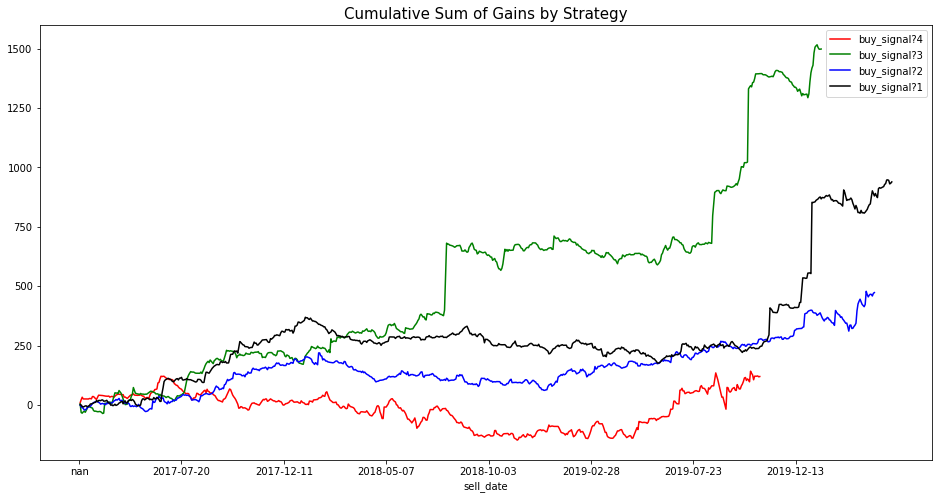

In [492]:
colors = ['red', 'green', 'blue', 'black']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(list_of_signals):
    rgl_df[rgl_df['strategy'] == signal]['$_gain'].cumsum().plot(figsize=(16,8), color=colors[idx], label=signal)

plt.legend()
plt.title('Cumulative Sum of Gains by Strategy', size=15);

### Holdings

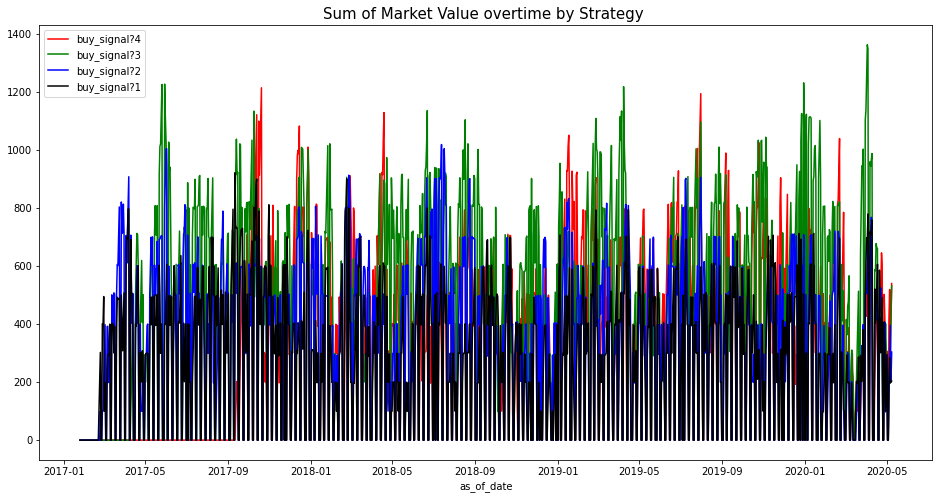

In [493]:
colors = ['red', 'green', 'blue', 'black']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(list_of_signals):
    holdings_df[holdings_df['strategy'] == signal].groupby(level=0).sum()['market_value'].plot(figsize=(16,8), color=colors[idx], label=signal)

plt.legend()
plt.title('Sum of Market Value overtime by Strategy ', size=15);


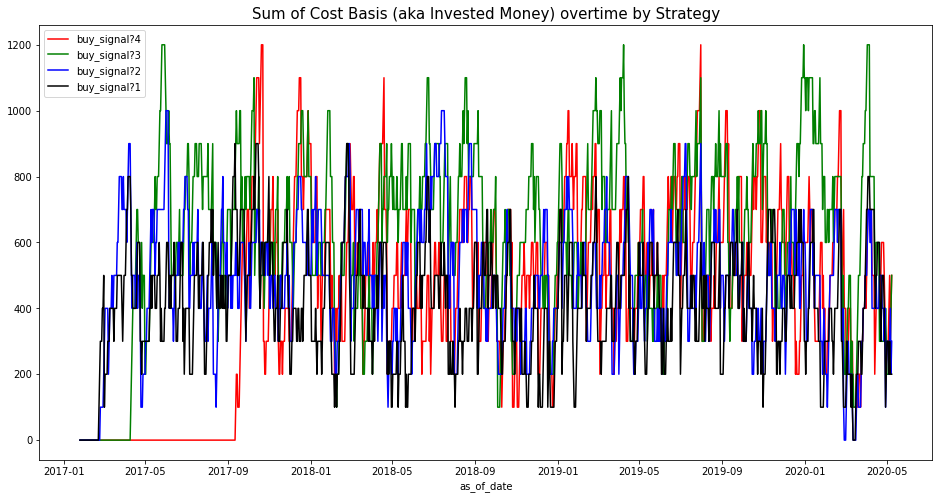

In [495]:
colors = ['red', 'green', 'blue', 'black']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(list_of_signals):
    holdings_df[holdings_df['strategy'] == signal].groupby(level=0).sum()['cost_basis'].plot(figsize=(16,8), color=colors[idx], label=signal)

plt.legend()
plt.title('Sum of Cost Basis (aka Invested Money) overtime by Strategy', size=15);